I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.stats.bayesian_blocks as bb
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('All', 'Bona'), value='Bona')

II. Define Baysian Blocks Representation

In [1]:
# 6. Lightcurve Plotter Function
def lc_plotter_fun(df_eventfiles_input,id_name,bin_size_sec):
    """
    DESCRIPTION: Plots lightcurves and cumulative counts for given eventfile input dataframe
    INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
    OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
    """
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(2, 2, figsize=(12, 6),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Create binned lightcurve
    df = df_eventfiles_input.copy()
    df['time'] = df_eventfiles_input['time'] - min(df_eventfiles_input['time'])
    df_binned = df.groupby(df['time'] // bin_size_sec * bin_size_sec).count()
    # Plot binned lightcurve
    axs[0,0].plot(df_binned.index/1000, df_binned, color = google_blue)
    axs[0,0].set_xlabel('Time [ks]')
    axs[0,0].set_ylabel('Counts per Bin')
    axs[0,0].set_title(f'Lightcurve with {bin_size_sec}s Bin Size')
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['time']/math.sqrt(3)
    # Plot rolling 3-bin averaged lightcurved
    axs[1,0].plot(df_rolling.index/1000, df_rolling, color = google_red)
    axs[1,0].errorbar(df_rolling.index/1000, df_rolling['time'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1,0].set_xlabel('Time [ks]')
    axs[1,0].set_ylabel('Counts per Bin')
    axs[1,0].set_title('Running Average of 3 Bins')
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative = df_cumulative.sort_values(by='time') 
    df_cumulative = df_cumulative.reset_index(drop=True) 
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Plot cumulative count plot
    axs[0,1].plot(df_cumulative['time']/1000, df_cumulative['cumulative_count'],color = google_green)
    axs[0,1].set_xlabel('Time [ks]')
    axs[0,1].set_ylabel('Cumulative Count')
    axs[0,1].set_title('Cumulative Count over Time')
    
    plt.show()
    return



Load Data

In [40]:
from matplotlib.colors import LogNorm
from sherpa.astro import ui

# Set ID
set_id = set_widget.value
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')
print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)


Number of Eventfiles:  62989
Number of Property Sets:  62989


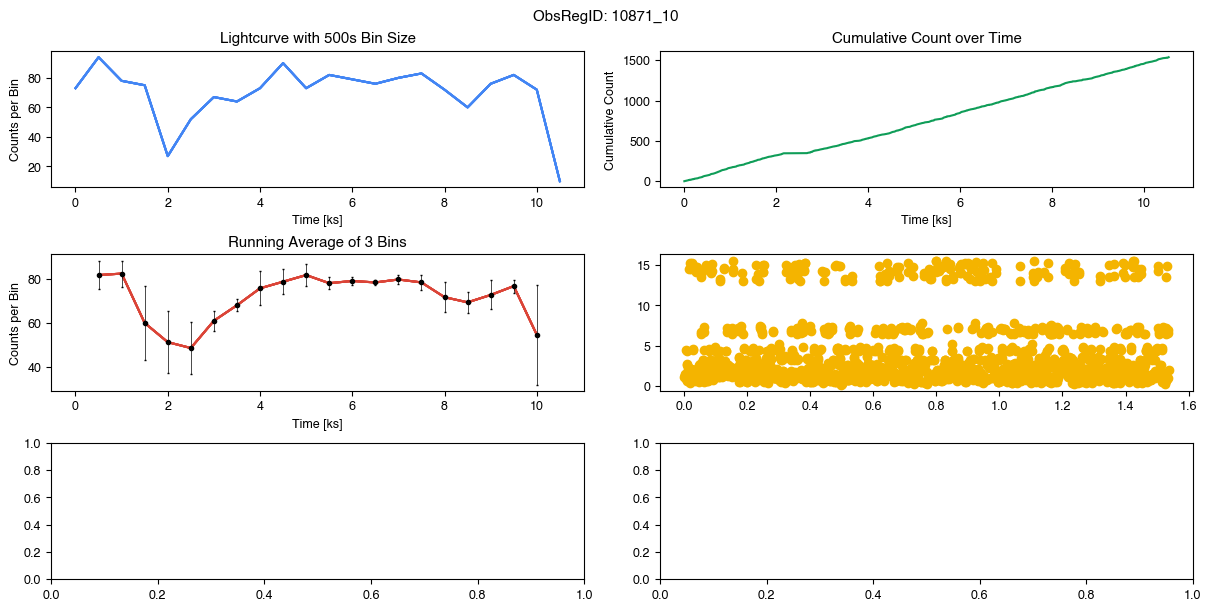

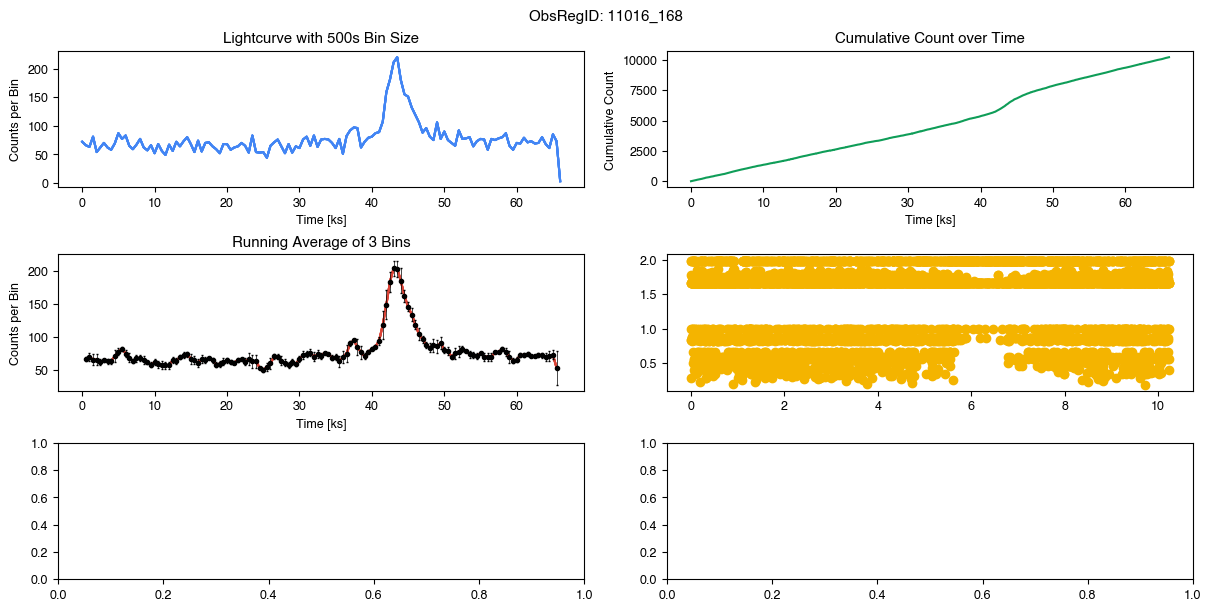

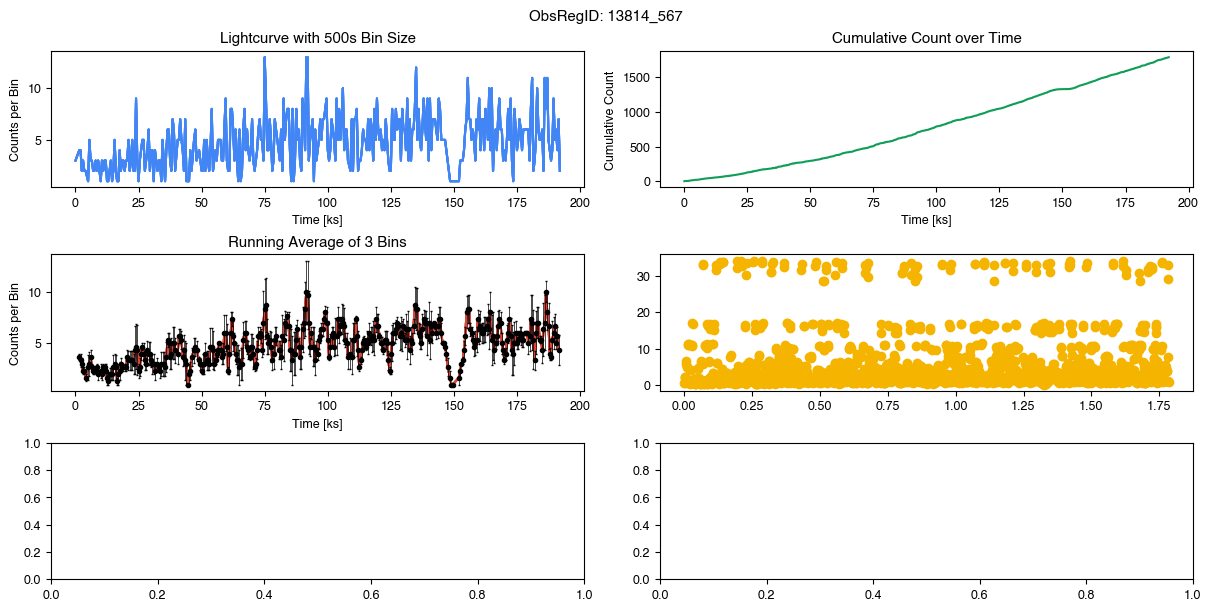

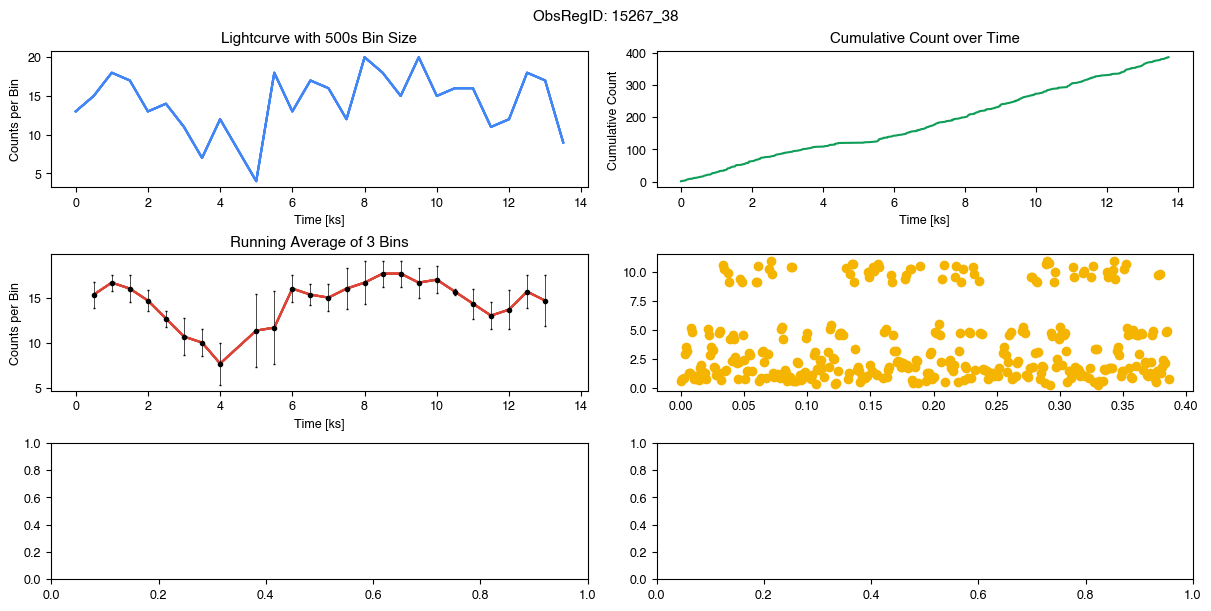

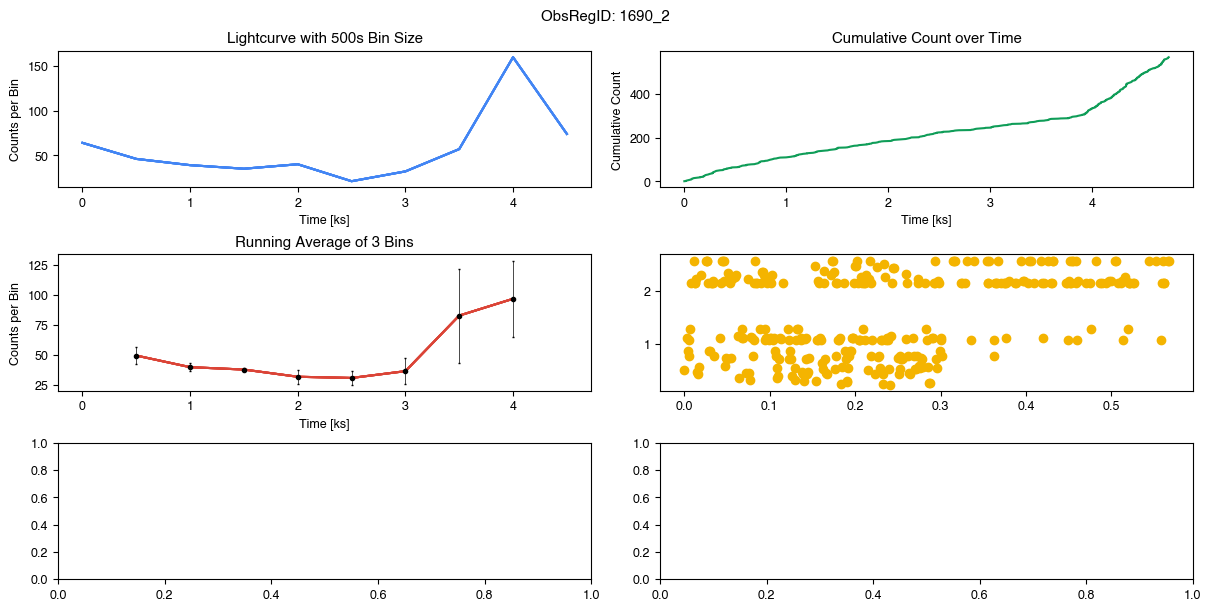

In [41]:
filter = ['10871_10','13814_567','15267_38','11016_168','1690_2']
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in filter).groupby('obsreg_id')
# Settings
Emin = np.log(500)
Emax = np.log(7000)
# E and dt binning
nbins_Eavg = 10 #19 #18
nbins_dtavg = 16  #32 #31
nbins_E75 = 11 #11 #10
nbins_dt75 = 21 #20 #18
nbins_E90 = 16 #15 #14
nbins_dt90 = 28 #27 #26
nbins_E95 = 20 #19 #18
nbins_dt95 = 33 #32 #31

nE = nbins_Eavg 
ndt = nbins_dtavg 
nt = 25
for id_name, dfi in df_eventfiles_group_filtered:
    lc_plotter_fun(dfi,id_name,500)
  

In [66]:
import numpy as np
import pandas as pd
import astropy.stats as astats
import matplotlib.pyplot as plt

# Define the number of energy bins to use
num_energy_bins = 20
count_limit = df_eventfiles_group.ngroups
count=0
# Determine the maximum number of time bins across all dataframes
opt_bins = []
for id_name, df in df_eventfiles_group:
    # Extract the time and energy columns from the dataframe
    t = (df['time'] - df['time'].min()) / (df['time'].max() - df['time'].min())
    # Compute the Bayesian blocks for the time axis
    bins = astats.bayesian_blocks(t, fitness='events', p0=0.06)
    # Determine the number of bins to use in the plot
    num_bins = len(bins) - 1
    opt_bins.append(bins)
    count = count + 1
    print(f'Counter: {count} / {count_limit}')
    clear_output(wait=True)




Counter: 62989 / 62989


In [69]:
print(len(opt_bins[0]))

2


In [70]:
n_bb = []
for i in opt_bins:
    nbins = len(i)
    n_bb.append(nbins)
    count = count + 1



Counter: 61999 / 62989


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
with open(f'{global_path}/{set_id}/n_bb-{set_id}-{bb}.pickle', "wb") as file:
    pickle.dump(bins, file)
with open(f'{global_path}/{set_id}/n_bb-{set_id}-{bb}.pickle', "rb") as file:
    n_bb = pickle.load(file)

t_binning_plotter(n_bb, n_bb,show_percentiles = True,xlim_N = [0,100],xlim_T = [0,100])

with open(f'{global_path}/{set_id}/bbbins-{set_id}-{bb}.pickle', "wb") as file:
    pickle.dump(bins, file)
with open(f'{global_path}/{set_id}/bbbins-{set_id}-{bb}.pickle', "rb") as file:
    bbb = pickle.load(file)

In [ ]:
# Loop over all dataframes in the list
for id_name, df in df_eventfiles_group_filtered:
    lc_plotter_fun(df,id_name,500)
    # Normalize time to range [0, 1]
    t = (df['time'] - df['time'].min()) / (df['time'].max() - df['time'].min())
    # Take the log10 of the energy column
    E = np.log10(df['energy'])
    E_min = np.log10(500)
    E_max = np.log10(7500)
    # Compute the Bayesian blocks for the time axis
    bins = astats.bayesian_blocks(t,fitness='events', p0=0.01)
    
    # Bin the energy axis using a fixed number of equal width bins
    hist, _, _ = np.histogram2d(t, E, bins=[bins, np.linspace(E_min, E_max, num_energy_bins+1)])
    
    # Reshape the histogram to a fixed size
    new_shape = (num_energy_bins, max_bins)
    hist = hist.reshape(new_shape)
    
    # Plot the histogram
    plt.imshow(hist.T, aspect='auto', origin='lower', extent=[0, 1, E.min(), E.max()], cmap='plasma')
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Log10(Energy)')
    plt.show()

In [35]:
import numpy as np
from astropy.stats import bayesian_blocks

# Set desired shape for histograms
hist_shape = (14, 10)

# Create empty arrays to store histograms
histograms = []

# Loop over list of dataframes
for id_name, dfi in df_eventfiles_group_filtered:
    # Determine optimal bin edges using Bayesian blocks
    t = (dfi['time']-min(dfi['time']))/(max(dfi['time'])-min(dfi['time']))
    E = np.log10(dfi['energy'])
    time_edges = bayesian_blocks(t,fitness='events', p0=0.1)
    energy_edges = np.linspace(E.min(), E.max(), 14)
    # Create common set 
    time_bins = np.linspace(0, 1, num=50)
    #Rebin each dataset using the common set of bins
    t_digitized = np.digitize(t, time_bins)

    # Create 2D histogram using optimal bin edges
    hist, x, y = np.histogram2d(t,E, bins=[time_edges,energy_edges])
    #print(hist_shape)
    desired_n = 100
    repeat_factor = int(np.ceil(desired_n / hist.shape[1]))
    replicated_hist = np.repeat(hist, repeat_factor, axis=1)
    split_hist = np.split(replicated_hist, 2, axis=1)[0]

    rebinned_hist, _, _ = np.histogram2d(np.arange(14), np.arange(100), bins=[np.arange(15), np.arange(101)], weights=split_hist.flatten())
   
    # Reshape histogram to desired shape using bilinear interpolation
    #hist = np.reshape(hist, hist_shape)
    histograms.append(hist)

    # Display the 2D histogram for the current DataFrame
    plt.imshow(rebinned_hist, aspect='auto')
    plt.xlabel('Time')
    plt.ylabel('Energy')

    # # Display the 2D histogram for the current DataFrame
    # plt.imshow(hist.T, origin='lower', extent=[time_edges[0], time_edges[-1], energy_edges[0], energy_edges[-1]], aspect='auto')
    # plt.xlabel('Time')
    # plt.ylabel('Energy')


    plt.show()


ValueError: x and y must have the same length.

In [34]:
print(split_hist)
print(hist)

[[ 18.  18.  18.  18.  18.  18.  18.  18.  14.  14.  14.  14.  14.  14.
   14.  14.  22.  22.  22.  22.  22.  22.  22.  22.  16.  16.  16.  16.
   16.  16.  16.  16.   9.   9.   9.   9.   9.   9.   9.   9.   1.   1.
    1.   1.   1.   1.   1.   1.   3.   3.   3.   3.]
 [ 49.  49.  49.  49.  49.  49.  49.  49.  64.  64.  64.  64.  64.  64.
   64.  64.  75.  75.  75.  75.  75.  75.  75.  75.  90.  90.  90.  90.
   90.  90.  90.  90.  36.  36.  36.  36.  36.  36.  36.  36.  11.  11.
   11.  11.  11.  11.  11.  11.   8.   8.   8.   8.]
 [105. 105. 105. 105. 105. 105. 105. 105. 131. 131. 131. 131. 131. 131.
  131. 131. 188. 188. 188. 188. 188. 188. 188. 188. 234. 234. 234. 234.
  234. 234. 234. 234. 130. 130. 130. 130. 130. 130. 130. 130.  45.  45.
   45.  45.  45.  45.  45.  45.  26.  26.  26.  26.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   2.   2.   2.   2.   2.   2.   2.   2.   3.   3.   3.   3.
    3.   3.   3.   3.   0.   0.   0.   0.   0.   